In [2]:
!pip install optimum-quanto
#restart kernal after installing
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 1.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.7 MB/s eta 0:00:00:00:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 62.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 56.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 27.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━

In [4]:
import os
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

import time
import copy
import numpy as np


/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [5]:
def evaluate_model(model, test_loader, device, criterion=None):

    model.eval()
    model.to(device)

    running_loss = 0
    running_corrects = 0

    for inputs, labels in test_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        if criterion is not None:
            loss = criterion(outputs, labels).item()
        else:
            loss = 0

        # statistics
        running_loss += loss * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    eval_loss = running_loss / len(test_loader.dataset)
    eval_accuracy = running_corrects / len(test_loader.dataset)

    return eval_loss, eval_accuracy


In [6]:
import torch.nn.functional as F
def test(model, device, test_loader):
    model.to(device)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        start = time.time()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            if isinstance(output, QTensor):
                output = output.dequantize()
            test_loss += F.nll_loss(output, target, reduction="sum").item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
        end = time.time()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set evaluated in {:.2f} s: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            end - start, test_loss, correct, len(test_loader.dataset), 100.0 * correct / len(test_loader.dataset)
        )
    )

In [7]:
def train_model(model,
                train_loader,
                test_loader,
                device,
                learning_rate=1e-1,
                num_epochs=200):

    criterion = nn.CrossEntropyLoss()

    model.to(device)

    optimizer = optim.SGD(model.parameters(),
                          lr=learning_rate,
                          momentum=0.9,
                          weight_decay=1e-4)
    
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=[100, 150],
                                                     gamma=0.1,
                                                     last_epoch=-1)

    # Evaluation
    model.eval()
    eval_loss, eval_accuracy = evaluate_model(model=model,
                                              test_loader=test_loader,
                                              device=device,
                                              criterion=criterion)
    print("Epoch: {:03d} Eval Loss: {:.3f} Eval Acc: {:.3f}".format(
        0, eval_loss, eval_accuracy))

    for epoch in range(num_epochs):

        # Training
        model.train()

        running_loss = 0
        running_corrects = 0

        for inputs, labels in train_loader:

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = running_corrects / len(train_loader.dataset)

        # Evaluation
        model.eval()
        eval_loss, eval_accuracy = evaluate_model(model=model,
                                                  test_loader=test_loader,
                                                  device=device,
                                                  criterion=criterion)
        
        scheduler.step()

        print(
            "Epoch: {:03d} Train Loss: {:.3f} Train Acc: {:.3f} Eval Loss: {:.3f} Eval Acc: {:.3f}"
            .format(epoch + 1, train_loss, train_accuracy, eval_loss,
                    eval_accuracy))

    return model


In [8]:
transform = transforms.Compose([
    transforms.Resize((32, 32)), # Resize to 32x32
    transforms.ToTensor(), # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize: mean and std for RGB channels
])

batch_size = 200

# Get dataset class object corresponding to train split
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Create data loader from train dataset object
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

# Get dataset class object corresponding to test split
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Create data loader from test dataset object
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

# Define the classes for CIFAR-10
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 101887847.00it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [9]:
from torch.utils.data import Subset
indices = torch.arange(0, 500)
test_subset = Subset(testset, indices)
small_test_loader = torch.utils.data.DataLoader(test_subset, batch_size=50,
                                          shuffle=True, num_workers=2)

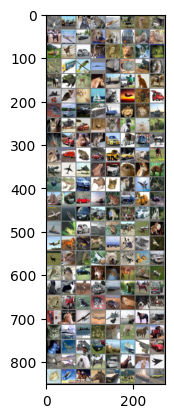

deer  airplane cat   frog  ship  horse bird  cat   horse airplane automobile dog   dog   truck horse frog  deer  horse automobile cat   bird  dog   cat   frog  bird  truck bird  airplane truck frog  truck cat   deer  frog  deer  horse truck truck cat   horse airplane cat   cat   ship  cat   airplane frog  automobile cat   ship  airplane automobile airplane frog  frog  ship  cat   horse automobile deer  cat   bird  cat   deer  deer  truck cat   cat   automobile truck automobile horse dog   truck frog  automobile truck automobile horse horse airplane airplane airplane frog  automobile dog   deer  deer  bird  frog  automobile bird  cat   cat   airplane frog  ship  truck automobile ship  frog  truck truck bird  airplane ship  automobile truck frog  deer  automobile dog   ship  frog  automobile ship  frog  horse airplane frog  airplane horse frog  horse automobile airplane cat   bird  deer  cat   frog  truck dog   airplane airplane automobile bird  dog   automobile frog  frog  horse bird  c

In [10]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [20]:
from optimum.quanto import Calibration, QTensor, freeze, qfloat8, qint4, qint8, qint2,quantize

In [12]:
import torch
import torch.nn as nn

class VGG16(nn.Module):
    def __init__(self, num_classes=100):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [13]:
def save_model(model, model_dir, model_filename):

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_filepath = os.path.join(model_dir, model_filename)
    torch.save(model.state_dict(), model_filepath)


def load_model(model, model_filepath, device):

    model.load_state_dict(torch.load(model_filepath, map_location=device))

    return model

In [14]:
cuda_device = torch.device("cuda:0")
cpu_device = torch.device("cpu:0")

model = VGG16(num_classes=10)

model = train_model(model=model,
                        train_loader=train_loader,
                        test_loader=test_loader,
                        device=cuda_device,
                        learning_rate=1e-1,
                        num_epochs=5)

Epoch: 000 Eval Loss: 2.303 Eval Acc: 0.100
Epoch: 001 Train Loss: 1.637 Train Acc: 0.377 Eval Loss: 1.706 Eval Acc: 0.429
Epoch: 002 Train Loss: 1.135 Train Acc: 0.600 Eval Loss: 1.218 Eval Acc: 0.584
Epoch: 003 Train Loss: 0.867 Train Acc: 0.699 Eval Loss: 0.834 Eval Acc: 0.713
Epoch: 004 Train Loss: 0.686 Train Acc: 0.768 Eval Loss: 0.731 Eval Acc: 0.757
Epoch: 005 Train Loss: 0.573 Train Acc: 0.810 Eval Loss: 0.778 Eval Acc: 0.748


In [15]:
print("trained model accuracy:")
test(model, cuda_device, test_loader)

trained model accuracy:

Test set evaluated in 1.88 s: Average loss: -5.9101, Accuracy: 7479/10000 (75%)



In [17]:
model_dir = "/kaggle/working/models/"
model_filename = "VGG16.pth"
model_filepath = model_dir + model_filename

save_model(model=model, model_dir=model_dir, model_filename=model_filename)

# Load a pretrained model.
model = load_model(model=model,
                   model_filepath=model_filepath,
                   device=cuda_device)

print("loaded model accuracy:")
test(model, cuda_device, test_loader)

loaded model accuracy:

Test set evaluated in 1.90 s: Average loss: -5.9101, Accuracy: 7479/10000 (75%)



In [18]:
def Quantize(model,weights_dtype,activations_dtype):
    quantize(model, weights=weights_dtype, activations=activations_dtype)
    print("Calibrating ...")
    with Calibration():
        test(model, cuda_device, test_loader)
    freeze(model)

In [26]:
weights = [qint8,qint4,qint2]
strs = ["int8.pth","int4.pth","int2.pth"]
activations = [qint8,qint4,qint2]

for i in range(3):
    model = VGG16(num_classes=10)
    model = load_model(model=model,
                   model_filepath=model_filepath,
                   device=cuda_device)
    Quantize(model = model,weights_dtype=weights[i],activations_dtype=activations[i])
    path = "/kaggle/working/models/"+strs[i]
    torch.save(model,path)

Calibrating ...

Test set evaluated in 3.23 s: Average loss: -6.5013, Accuracy: 7450/10000 (74%)

Calibrating ...


/opt/conda/lib/python3.10/site-packages/optimum/quanto/library/ops.py:66: UserWarning: An exception was raised while calling the optimized kernel for quanto::unpack: /root/.cache/torch_extensions/py310_cu121/quanto_cuda/quanto_cuda.so: cannot open shared object file: No such file or directory Falling back to default implementation.
  warnings.warn(message + " Falling back to default implementation.")



Test set evaluated in 3.63 s: Average loss: -6.4547, Accuracy: 7428/10000 (74%)

Calibrating ...

Test set evaluated in 3.14 s: Average loss: -4.9682, Accuracy: 6541/10000 (65%)



In [30]:
int8_model = torch.load("/kaggle/working/models/int8.pth")
int4_model = torch.load("/kaggle/working/models/int4.pth")
int2_model = torch.load("/kaggle/working/models/int2.pth")

print("int8 model:")
test(int8_model, cuda_device, test_loader)
print("int4 model:")
test(int4_model, cuda_device, test_loader)
print("int2 model:")
test(int2_model, cuda_device, test_loader)

int8 model:

Test set evaluated in 2.05 s: Average loss: -5.9120, Accuracy: 7485/10000 (75%)

int4 model:

Test set evaluated in 2.19 s: Average loss: -5.8648, Accuracy: 7460/10000 (75%)

int2 model:

Test set evaluated in 2.19 s: Average loss: -4.5971, Accuracy: 6560/10000 (66%)



# **QAT for int2 model**

In [31]:
quantize(int2_model, weights=qint2, activations=qint2)
print("Calibrating ...")
with Calibration():
    test(int2_model, cuda_device, test_loader)

qat_int2_model = train_model(model=int2_model,
                        train_loader=train_loader,
                        test_loader=test_loader,
                        device=cuda_device,
                        learning_rate=1e-1,
                        num_epochs=2)

test(int2_model, cuda_device, test_loader)

freeze(int2_model)
print("after freezing:")
test(int2_model, cuda_device, test_loader)

Calibrating ...

Test set evaluated in 3.20 s: Average loss: -4.9682, Accuracy: 6541/10000 (65%)

Epoch: 000 Eval Loss: 1.097 Eval Acc: 0.656
Epoch: 001 Train Loss: 0.410 Train Acc: 0.862 Eval Loss: 0.576 Eval Acc: 0.810
Epoch: 002 Train Loss: 0.364 Train Acc: 0.876 Eval Loss: 0.648 Eval Acc: 0.794

Test set evaluated in 2.67 s: Average loss: -7.1901, Accuracy: 7935/10000 (79%)

after freezing:

Test set evaluated in 2.17 s: Average loss: -7.1901, Accuracy: 7935/10000 (79%)

